# Exploring the data, basic fitting and visualization

#### Handle the imports

In [1]:
#First import the standard toolboxes
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd

#Import the specific functions for this class
import encoding_tools

#Import some sklearn functions


#### Download the data from the gdrive and load it

In [2]:
data_file = encoding_tools.download_neural_data("miniscope") #Download function from io
data_dict = np.load(data_file, allow_pickle = True).tolist()

#Create a variable for each keyword in the dictionary
for key,val in data_dict.items():
        exec(key + '=val')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8
From (redirected): https://drive.google.com/uc?id=1JT0TcbWDKsB90CRMy0XX8dCSaO7Dxvi8&confirm=t&uuid=74eb9007-346d-4d4c-886c-c8af2d17f37c
To: C:\Users\Lukas Oesch\Documents\ChurchlandLab\DataSAI_data_folder\miniscope_data.npy
100%|██████████████████████████████████████████████████████████████████████████████| 1.30G/1.30G [00:11<00:00, 110MB/s]


#### What are these data?

The data we have loaded were obtained from a mouse performing a 2AFC task discriminating between high-frequency (> 12 Hz) and low-frequency (< 12 Hz) click trains. We recorded excitatory neurons in the anterior cingulate cortex of this mouse during the task performance while video tracking the animal's movements. What do the indiviudal variables mean?

<ul>
    <li> <strong>desing_matrix</strong>: This is the heart of the encoding model we are going to build. It contains a set of task and movement variables aligned to four distinct phases of the task, size is number of total frames x regressor number.</li>
 <li><strong>Y_raw_fluorescence</strong>: The fluorescence traces from all the neurons recorded algined to the same task phases as the task- and movement variables, size is number of total frames x neuron number</li>
 <li><strong>neuron_footprints</strong>: The spatial filters for the recorded neurons, size is 300 pixels x 300 pixels x neuron number. </li>
 <li><strong>timepoints_per_trial</strong>: The number of frames per trial.</li>
  <li><strong>frame_rate</strong>: The acquisition frame rate for the miniscope data.</li>
  <li><strong>aligned_segment_start</strong>: Marks the frames where the activity was aligned to a new task event. This means that these frames are discontinuous to the previous ones.</li>
 </ul>


## Exercise 1: What is the structure of the design matrix?

Lets start by looking at the task variables inside the design matrix:

<ul>
    <li>time (the intercept per trial timepoint)</li>
    <li>choice</li>
    <li>stimulus strength</li>
    <li>outcome</li>
    <li>previous choice</li>
    <li>previous outcome</li>
</ul> 

Let's  print some of the keys of the data frame and plot the task variable columns!

Index(['time_t0', 'choice_t0', 'stim_strength_t0', 'outcome_t0',
       'previous_choice_t0', 'previous_outcome_t0'],
      dtype='object')


<IPython.core.display.Javascript object>


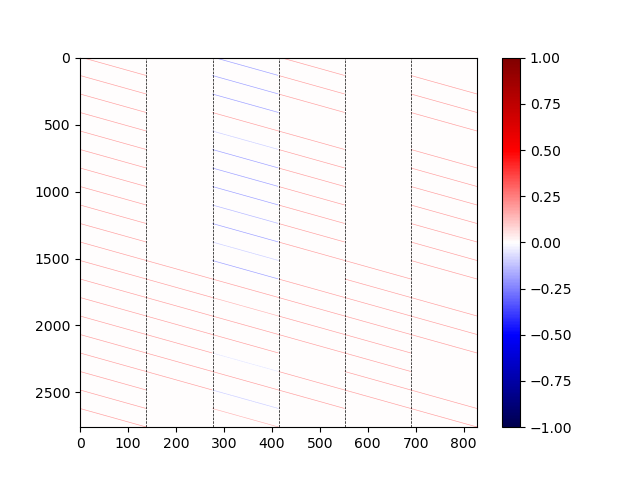

In [3]:
#Print some of the keys of the design matrix
print(design_matrix.keys()[np.arange(0,6 * timepoints_per_trial, timepoints_per_trial)])

#Plot the task variables
plt.figure()
plt.imshow(np.array(design_matrix)[:20 * timepoints_per_trial,:6 * timepoints_per_trial], aspect = 'auto', cmap = 'seismic')
#use np.array() on the design_matrix to be able to index numerically instead of by key
for k in range(6):
    plt.axvline(k * timepoints_per_trial, color='k', linestyle='--', linewidth=0.5)
plt.colorbar()

######---Try answering the following questions:
# Does the t0 on the keys mean?
# Why is the first column bounded by dashed lines all diagonals?
# Why are the other ones not all diagonals?
# What do negative values along the diagonal indicate?

<IPython.core.display.Javascript object>


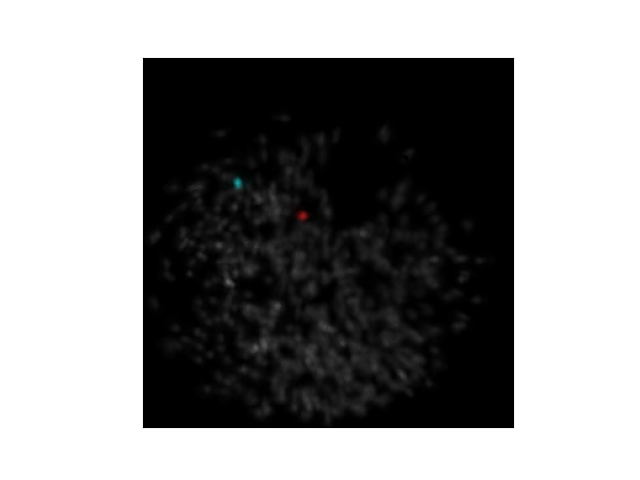

In [4]:
#Plot two example neurons: neuron 56 in red and neuron 12 in cyan superimposed on top of all the other identified cells
encoding_tools.overlay_neurons(neuron_footprints, 56, 12, 12) #Pass the neuron ids for the red, green and blue channel

## Exercise 2: How do task variables affect the activity of ACC neurons?

The aim of this exercise is to plot per-event time histograms (PETHs) for two neurons for different choices and outcomes. 

<ol>
    <li> Extract the choice and outcomes for each trial from the design matrix. </li>
    <li> Reshape the response matrix, Y_raw_fluorescence, to be a 3-dimensional array refelcting time, neuron id and trial number. </li>
    <li> Complete the missing lines of code in the function that calculates and plots the mean +/- sem trace for a respective binary value of a task variable </li>


<IPython.core.display.Javascript object>


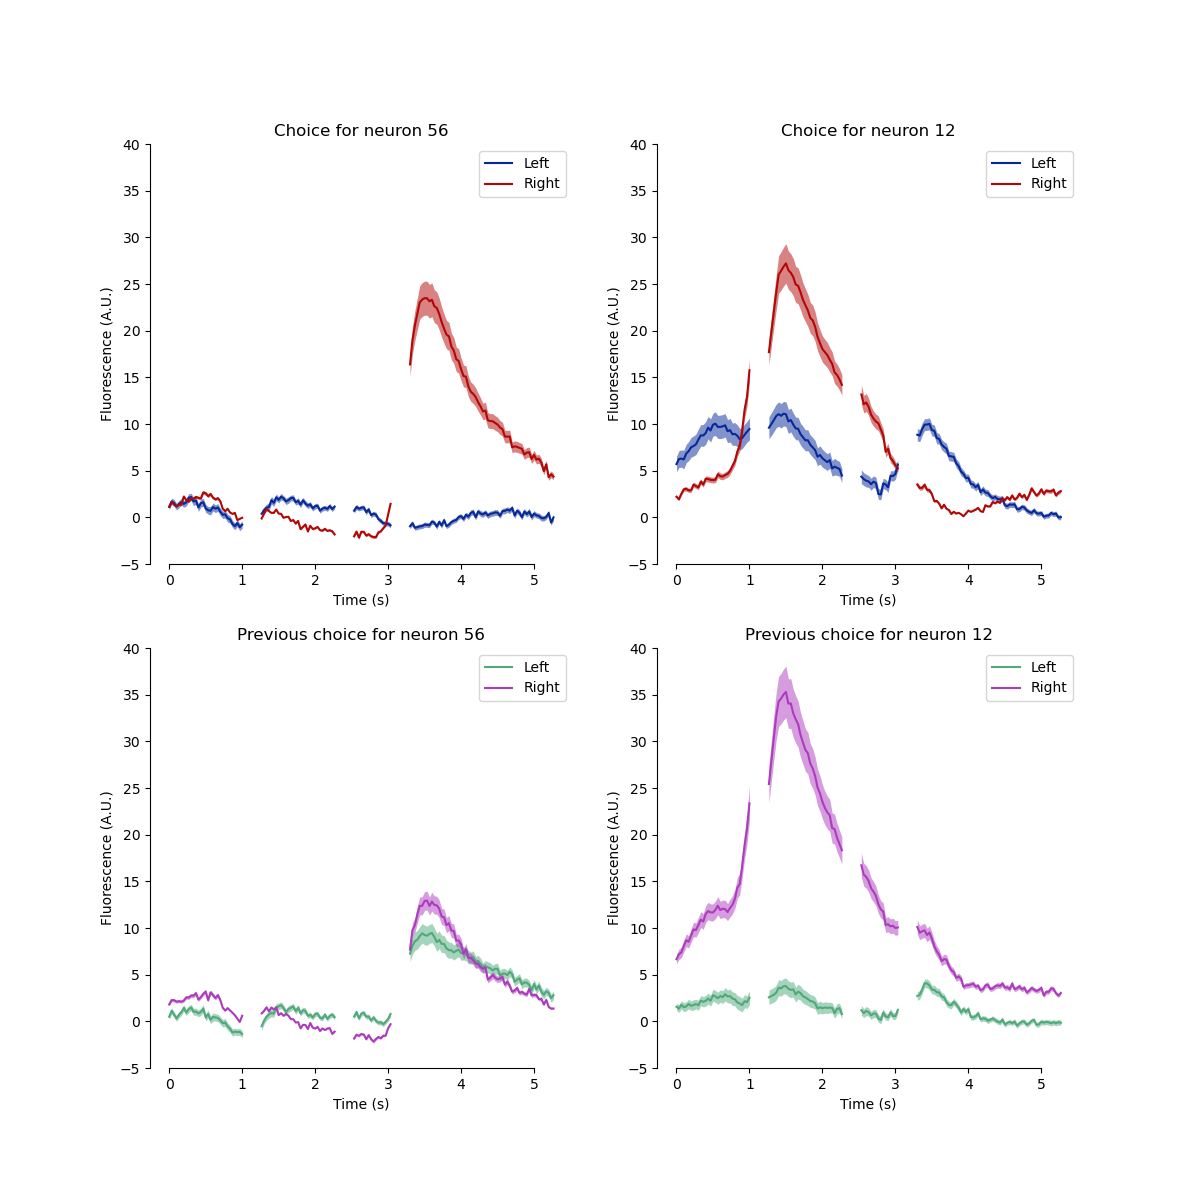

In [4]:
# 1. Extract choice and previous_choice for each trial from the design matrix: Use what you have learned about the
#    structure of the design matrix to generate a vector of choices and previous_choices, one entry per trial.

# TODO: Inser your code here

#######-------Solution--------------##################################################
#Linear indexing solution as a one-liner
choice = design_matrix['choice_t0'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]
previous_choice = design_matrix['previous_choice_t0'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]
#Important here: The start of the range has to correspond with the respective regressor timepoint. One could also
#use choice = design_matrix['choice_t1'][np.arange(0, design_matrix.shape[0], timepoints_per_trial)]

#Alternative: Looping through the first choice and outcome column jumping a block size each time
choice = []
previous_choice = []
for k in range(0, design_matrix.shape[0], timepoints_per_trial):
    #Here k loops through 0, 138, 276, ... because the task variable regressors are only valid in their respective time
    #if we loop through timepoint t0 (as we do because we start k at 0) we need to take the respective column in the pandas
    #data frame, here choice_t0.
    choice.append(design_matrix['choice_t0'][k])
    previous_choice.append(design_matrix['previous_choice_t0'][k])

#Convert to numpy arrays for convenience
choice = np.array(choice)
previous_choice = np.array(previous_choice)

#Note the choice and previous_choice are extracted from valid trials and they might not be sequential!
###################################################

# 2. Reshape the response matrix to obtain a timepoints x neuron id x trial array.

# TODO: Inset your code here

############----------Solution----------------------############
#Reshape and transpose
Y_3d = np.reshape(Y_raw_fluorescence.T, (Y_raw_fluorescence.shape[1], int(design_matrix.shape[0]/timepoints_per_trial), timepoints_per_trial)).transpose(2,0,1)
#This works the following way: reshape (when using C mode) takes sampes along the last axis of the input array first
#and adds them to the last axis of the output array. By first transposing the response matrix (.T notation) we make sure 
#that moving along axis 1 moves along the timepoints. By adding timepoints to the last axis of the new array and starting
#a new count of the second last axis after each trial we can construct first a 3d array where the axes initially are: 
#neuron id, trial, timepoint. By using transpose again and specifying the order of the axes we can recover a
#timepoints x neuron id x trials array.

#Alternative: loop through the timepoints
#######################################################

# 3. Please complete the function below that can be used to calculate and plot mean +/- sem traces for a specified neuron
#    and a specific binary task variable.

def plot_mean_trace(Y_3d, task_var, task_var_name, neuron_id, aligned_segment_start, ax, colors = ['#062999','#b20707'], spacer = 7, var_value_strings = ['Left', 'Right']):

    
    average_trace = np.stack((np.mean(Y_3d[:, neuron_id, task_var == 0],axis=1), np.mean(Y_3d[:, neuron_id, task_var == 1],axis=1))).T
# TODO: Similarly construct the sem_trace variable
    
#########-----Solution----------#######
    sem_trace = np.stack((np.std(Y_3d[:, neuron_id, task_var == 0],axis=1) / np.sqrt(np.sum(task_var == 0)),
                          np.mean(Y_3d[:, neuron_id, task_var == 1],axis=1) / np.sqrt(np.sum(task_var == 1)))).T
##############################################
    
    for n in range(average_trace.shape[1]): #Loop through the average traces
        for k in range(len(aligned_segment_start)): #Loop through the different task segments
            
            if k < len(aligned_segment_start) - 1 : #Split by different segments
                plot_idx = np.arange(aligned_segment_start[k], aligned_segment_start[k+1]) #Extract indices of the current segment
                x_vect = (plot_idx + k*spacer) / frame_rate #Create a time vector to plot the data to
                line_label = None 
            else:
                plot_idx = np.arange(aligned_segment_start[k], Y_3d.shape[0])
                x_vect = (plot_idx + k*spacer) /frame_rate
                line_label = var_value_strings[n] #only use a label on the last segment

# TODO: Plot the sem and the average traces of the respective segment agains the time vector
#       to the axes ax using fill_between and plot methods. Remember that we are not only looping
#       through aligned segments but also through task variable conditions (True or False).
#       As keyword arguments for fill_between use: color = colors[n], alpha = 0.5, linewidth = 0
#       As keyword aruments to plot use: color = colors[n], label = line_label

#################----------Solution--------##############################
            ax.fill_between(x_vect, average_trace[plot_idx,n] - sem_trace[plot_idx,n], average_trace[plot_idx,n] + sem_trace[plot_idx,n], color = colors[n], alpha = 0.5, linewidth=0)
            ax.plot(x_vect, average_trace[plot_idx,n], color = colors[n], label = line_label)
###########################################################################
    
    #Do some figure formating
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fluorescence (A.U.)')
    ax.set_title(f'{task_var_name} for neuron {neuron_id}')
    ax.legend()
    ax.set_ylim([-5, 40]) #Pre-set for this data
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds([ax.get_yticks()[0], ax.get_yticks()[-1]]) 
    ax.spines['bottom'].set_bounds([ax.get_xticks()[1], ax.get_xticks()[-2]]) #IN this case the plotting is bounded by invisible ticks, thus 1 and -2
    return


#Now lets call our function and plot the traces!

#First create a figure with four subplots
axes_list = encoding_tools.create_subplot_axes(2, 2) #From visualizations

#Now we can fill the subplots
plot_mean_trace(Y_3d, choice, 'Choice', 56, aligned_segment_start, axes_list[0])
plot_mean_trace(Y_3d, choice, 'Choice', 12, aligned_segment_start, axes_list[1])
plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 56, aligned_segment_start, axes_list[2], colors = ['#4fa97a', '#ac3cbd'])
plot_mean_trace(Y_3d, previous_choice, 'Previous choice', 12, aligned_segment_start, axes_list[3], colors = ['#4fa97a', '#ac3cbd'])

In [4]:
?

Object `create_subplot_axes` not found.
